# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 ноября, -4 балла после 06:00 24 ноября, -6 баллов после 06:00 1 декабря, -8 баллов после 06:00 8 декабря.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

%load_ext pycodestyle_magic

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Моисеев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. Логистическая регрессия в ней в параграфе 4.3

Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
где $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал тогда принимает вид:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту регуляризацию в функцию потерь.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации. Отметим, что вне зависимости от алгоритма оптимизации, данная модель все равно будет называться ***логистической регрессией***.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь c L1-регуляризацией  могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для логистической регрессии.
* Посчитайте градиент функции потерь по весам для модели логистической регрессии с конкретно Вашей регуляризацией:

$$ \nabla_w L = \dots $$

 Отнеситесь к этому пункту максимально серьезно, этот градиент Вам нужно будет реализовать в задании.

***Решение***

$$
    L(w) = - \dfrac{1}{N}\left[\sum_i y_i \log \sigma(w^T x_i) + (1 - y_i) \log (1 - \sigma(w^T x_i)) \right] + \dfrac{1}{C}\sum_{j=1}^{D}w_j^2
$$
при $\sigma(z) = \frac{1}{1 + \exp(-z)}$.

Найдём $\dfrac{\partial L(w)}{\partial w_j}$:
$$
    \dfrac{\partial L(w)}{\partial w_j} = - \dfrac{1}{N}\left[\sum_i \left( \dfrac{y_i}{\sigma(w^T x_i)} - \dfrac{1 - y_i}{1 - \sigma(w^T x_i)}\right) \dfrac{\partial \sigma(w^T x_i)}{\partial w_j} \right] + \dfrac{2}{C}w_j,
$$
причём $\sigma'(z) = \sigma(z)(1 - \sigma(z))$, $\dfrac{\partial w^T x_i}{\partial w_j} = x_i^j$, где $x_i = (x_i^1, \dots, x_i^D)$. С учётом $y_i (1 - \sigma(z)) - (1 - y_i)\sigma(z) = y_i - \sigma(z)$, окончательно имеем
$$
    \nabla_w L = \dfrac{1}{N}\left[\sum_i \left(a(x_i) - y_i\right)x_i \right] + \dfrac{2}{C}w.
$$

Задача 2. Анализ поведения градиента.

Посчитав формулу градиента, подумайте, как будут меняться веса в зависимости  от "вида" ошибки: 
* Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

* Если правильный ответ был  класс "0", а значение $a(x_i)$ близко к  единице, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

Вам такое поведение кажется логичным?

***Решение***

Будем действовать в предположении о том, что $C \gg 1$ и регуляризация незначительно влияет на результаты. В первом случае выражение $a(x_i) - y_i < 0$, и вес $w_j$ вырастет при $x_i^j > 0$ и уменьшится для $x_i^j < 0$, что увеличит произведение $w^T x_i$. Это "сдвинет" предсказание для $x_i$ вправо по графику сигмоиды, приближая значение $a(x_i)$ к единице, что логично, ведь для правильного прогноза там ей быть и следует. Аналогично во втором случае произведение $w^T x_i$ уменьшится после шага градиентного спуска для того, чтобы отдалить $a(x_i)$ от единицы.

Задача 3. Сравнение с линейной регрессией.

Как было рассказано на лекции, функция потерь линейной регрессии без регуляризации имеет вид:
$$ L( w ) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] $$
где $a(x_i)$ предсказания модели на $i$ объекте, $y_i$ $-$ значение целовой переменной на $i$ объекте, $N$ $-$ размер выборки.
$a(x_i)$ через веса и признаки вычисляется как:
$$ a(x_i) =  \langle\,x_i,w\rangle $$
где $x_i$ $-$ вектор признаков, $w$ $-$ вектор весов модели.
* Посчитайте градиент  функции потерь по весам для модели линейной регрессии:
$$ \nabla_w L = \dots $$
Как соотносится этот градиент с градиентом, возникающий в задаче логистической регресии? Вас это удивило, Вы это уже раньше заметили или Вам все равно? 

***Решение***

$$\dfrac{\partial L}{\partial w_j}= \frac{2}{N}\left[\sum_i (w^T x_i - y_i) \dfrac{\partial w^T x_i}{\partial w_j} \right],$$
$$\nabla_w L = \dfrac{1}{N}\left[\sum_i \left(a(x_i) - y_i \right)x_i \right].
$$

Таким образом, формулы для градиента функции потерь (естественно, для одинаковых регуляризаций) в случае линейной и логистической регрессии совпадают. Я уже знал об этом, впрочем, каждый раз удивляюсь как в первый.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Решение***

Решим уравнение $\dfrac{d E(L|x_i)}{d a(x_i)} = 0$ относительно $a(x_i)$ для выпуклой функции $E(L|x_i)$:
$$\dfrac{d E(L|x_i)}{d a(x_i)} = -p(y_i = 1 |x_i) \dfrac{1}{a(x_i)} + p(y_i = 0 | x_i) \dfrac{1}{1 - a(x_i)}, $$
$$-p(y_i = 1 |x_i)(1 - a^0(x_i)) + p(y_i = 0 | x_i) a^0(x_i) = 0, $$
$$a^0(x_i) = p(y_i = 1 |x_i).$$


#  Реализация логистической регрессии (6 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [122]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [123]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [127]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [128]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y          - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    n = y.shape[0]
    indices = np.arange(n)
    if shuffle is True:
        np.random.shuffle(indices)

    for i in range(0, y.shape[0], batch_size):
        batch_ind = indices[i: min(i + batch_size, n)]
        X_batch = X[batch_ind]
        y_batch = y[batch_ind]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [53]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(X, weights):
    """
    Вычисляем значение сигмоида.
    X - матрица объекты-признаки
    weigths - веса признаков
    """
    return 1 / (1 + np.exp(- X.dot(weights)))


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10, batch_size=5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.batch_size = batch_size
        self.weights = None

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        N = y_batch.shape[0]
        sigma = sigmoid(X_batch, self.weights)
        return -(y_batch.dot(sigma) + (1 - y_batch).dot(1 - sigma)) / N + \
                (self.weights ** 2).sum() / self.C

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
        (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        N = y_batch.shape[0]
        sigma = sigmoid(X_batch, self.weights)
        return (sigma - y_batch).dot(X_batch) / N + 2 * self.weights / self.C

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad
        return

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        X_ext = np.c_[np.ones((X.shape[0], 1)), X.astype(float)]
        self.weights = np.random.rand(X_ext.shape[1])

        for n in range(0, self.max_epoch):
            new_epoch_generator = \
                self.batch_generator(X_ext, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        '''
        X_ext = np.c_[np.ones((X.shape[0], 1)), X.astype(float)]
        ans = sigmoid(X_ext, weights)
        ans[ans >= 0.5] = 1
        ans[ans < 0.5] = 0
        return ans

    def predict_proba(self, X):
        '''
        Предсказание вероятности положительного класса
        X - матрица объекты-признаки
        '''
        X_ext = np.c_[np.ones((X.shape[0], 1)), X.astype(float)]
        return sigmoid(X_ext, self.weights)

Запустите ваш алгоритм на синтетических данных. 

Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [54]:
def plot_decision_boundary(clf, x_min, x_max):
    weights = clf.weights[:3]
    X = np.arange(x_min, x_max, (x_max - x_min) / 100)
    y = - (weights[0] + weights[1] * X) / weights[2]
    plt.plot(X, y)

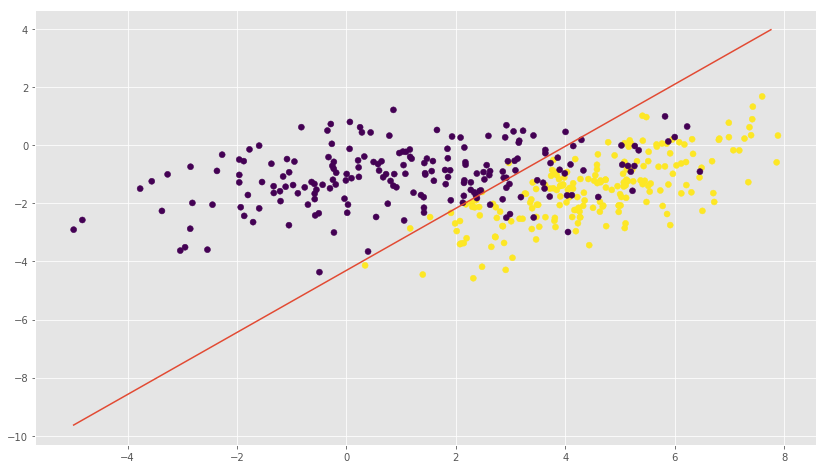

In [55]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_clf = MySGDClassifier(batch_generator, alpha=0.1, C=1000)
my_clf.fit(X, y)
plot_decision_boundary(my_clf, X[:,0].min(), X[:,0].max())

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [56]:
from sklearn.datasets import make_classification

In [57]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [58]:
clf_dict = {}
for alpha in np.logspace(-5, -0.2, 5):
    clf_dict[alpha] = MySGDClassifier(batch_generator, alpha=alpha, batch_size=10)
    clf_dict[alpha].fit(X, y)

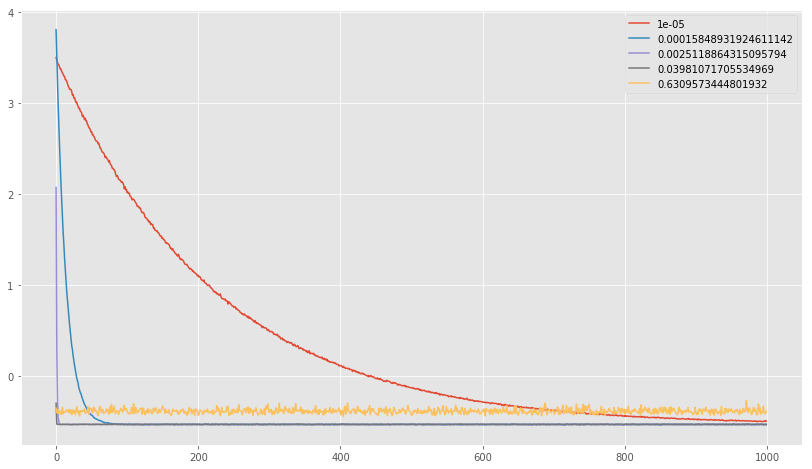

In [59]:
N = 100

for alpha, my_clf in clf_dict.items():
    loss_func = np.array(my_clf.errors_log['loss'])
    loss_mean = np.zeros((loss_func.shape[0] - 1) // N + 1)

    for ind in range(loss_mean.shape[0]):
        loss_mean[ind] = loss_func[ind * N: min((ind + 1) * N,
                                                loss_func.shape[0])].mean()
        
    plt.plot(loss_mean, label=alpha)
    
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

C уменьшением `alpha` уменьшается скорость сходимости; в то же время с его увеличением усиляется осциллирование функции потерь в окрестности минимума, что при очень больших значениях вообще может привести к низкой точности и непопаданию в минимум.

Для данной задачи оптимальным при данных параметрах будет значение `alpha` порядка $10^{-4}$.

Изобразите график среднего значения весов модели в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [60]:
clf_dict = {}
alpha=0.001

for C in np.logspace(3, -3, 20):
    clf_dict[C] = MySGDClassifier(batch_generator, 
                                  C=C, alpha=alpha, batch_size=10)
    clf_dict[C].fit(X, y)

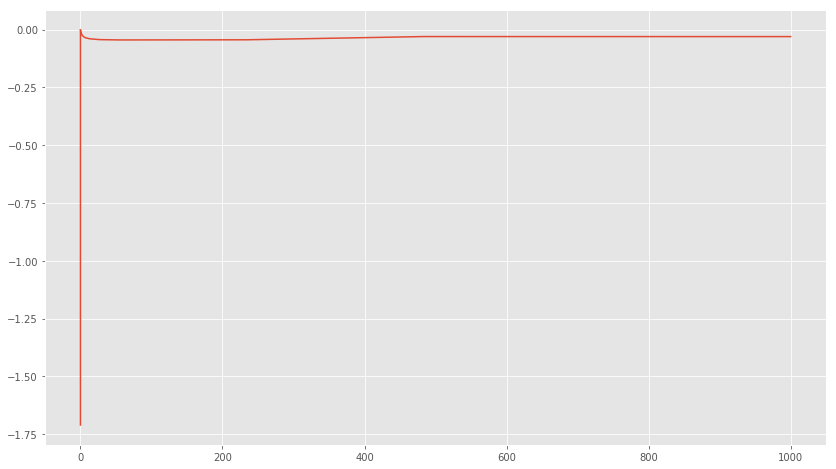

In [61]:
pltl_X = []
pltl_Y = []
for C, my_clf in clf_dict.items():
    pltl_X.append(C)
    pltl_Y.append(my_clf.weights.mean())
    
plt_X = np.array(pltl_X)
plt_Y = np.array(pltl_Y)
plt.plot(plt_X, plt_Y)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? Если нет, то как можно было бы уменьшать их еще сильнее?

Сложно делать какие-то выводы о качестве модели лишь по величине весов; прямая проверка точности на каком-нибудь тестирующем сете даст более явные намёки на существование или отсутствие overfitting'а. Попробовать уменьшить веса ещё сильнее можно какой-либо предобработкой значений признаков или изменением размеров тренировочного сета.

# Боевое применение (2  балла)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная онлайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [62]:
# Загрузка данных для обучения
filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [63]:
df_data.head(10)

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14
5,2993360,0,13,0,0,612,26,0,0,10,...,9,9,5,0,0,5,0,19,25,25
6,4378268,0,9,0,0,612,20,0,0,9,...,8,8,5,1,0,6,6,23,30,23
7,3774658,1,2,0,0,390,30,0,0,1,...,0,0,4,1,0,5,1,22,25,25
8,3956442,1,12,2,0,1235,18,0,0,10,...,2,6,2,1,1,4,4,12,15,10
9,2958739,1,10,0,0,1235,16,0,0,9,...,18,19,2,0,0,2,0,5,7,6


In [64]:
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [65]:
df_data.head(10).T

gamestate_id,4687346,3270826,3189487,4098946,2661127,2993360,4378268,3774658,3956442,2958739
decision,1,1,1,1,0,0,0,1,1,1
turn,14,7,5,8,13,13,9,2,12,10
opponent_armor,0,0,3,0,0,0,0,0,2,0
opponent_attack,0,0,0,0,0,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25,612,612,390,1235,1235
opponent_hp,5,22,29,26,30,26,20,30,18,16
opponent_special_skill_used,0,0,0,0,0,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10,10,9,1,10,9
opponent_crystals_current,10,6,1,7,1,3,2,1,2,1


In [66]:
# Распределение классов
df_data.decision.mean()

0.504702

## Обучение модели

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы. (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Стандартизируйте признаки с помощью `StandartScaller` из sklearn (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Обучите модель, подбирая параметры на отложенном контроле

In [67]:
#линейно зависимо с player_hand_nOfMinions, player_hand_nOfWeapons, player_hand_nOfSpells
df_data = df_data.drop(['player_hand_nOfCards'], axis='columns')

In [68]:
df_data.opponent_hero_card_id.value_counts()

798     67578
494     63623
25      62067
1235    60777
612     53141
981     51628
326     50802
754     46006
390     44378
Name: opponent_hero_card_id, dtype: int64

In [69]:
oplist = df_data['opponent_hero_card_id'].tolist()

df_data['opponent_hero_card_id_is_798'] = [1 if x == 798 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_494'] = [1 if x == 494 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_25'] = [1 if x == 25 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_1235'] = [1 if x == 1235 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_612'] = [1 if x == 612 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_981'] = [1 if x == 981 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_326'] = [1 if x == 326 else 0 for x in oplist]
df_data['opponent_hero_card_id_is_754'] = [1 if x == 754 else 0 for x in oplist]

df_data = df_data.drop(['opponent_hero_card_id'], axis='columns')

In [70]:
pllist = df_data['player_hero_card_id'].tolist()

df_data['player_hero_card_id_is_798'] = [1 if x == 798 else 0 for x in pllist]
df_data['player_hero_card_id_is_494'] = [1 if x == 494 else 0 for x in pllist]
df_data['player_hero_card_id_is_25'] = [1 if x == 25 else 0 for x in pllist]
df_data['player_hero_card_id_is_1235'] = [1 if x == 1235 else 0 for x in pllist]
df_data['player_hero_card_id_is_612'] = [1 if x == 612 else 0 for x in pllist]
df_data['player_hero_card_id_is_981'] = [1 if x == 981 else 0 for x in pllist]
df_data['player_hero_card_id_is_326'] = [1 if x == 326 else 0 for x in pllist]
df_data['player_hero_card_id_is_754'] = [1 if x == 754 else 0 for x in pllist]

df_data = df_data.drop(['player_hero_card_id'], axis='columns')

In [71]:
df_data.head(10).T

gamestate_id,4687346,3270826,3189487,4098946,2661127,2993360,4378268,3774658,3956442,2958739
decision,1,1,1,1,0,0,0,1,1,1
turn,14,7,5,8,13,13,9,2,12,10
opponent_armor,0,0,3,0,0,0,0,0,2,0
opponent_attack,0,0,0,0,0,0,0,0,0,0
opponent_hp,5,22,29,26,30,26,20,30,18,16
opponent_special_skill_used,0,0,0,0,0,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10,10,9,1,10,9
opponent_crystals_current,10,6,1,7,1,3,2,1,2,1
opponent_deck_count,11,19,22,17,12,10,17,25,13,16


In [72]:
data = df_data.values

In [73]:
from sklearn.model_selection import train_test_split


X = data[:, 1:].astype(float)
y = data[:, 0]

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X)

X_train, X_cross, y_train, y_cross = train_test_split(
    X, y, test_size=0.1)

CPU times: user 20.1 s, sys: 1.34 s, total: 21.4 s
Wall time: 13 s


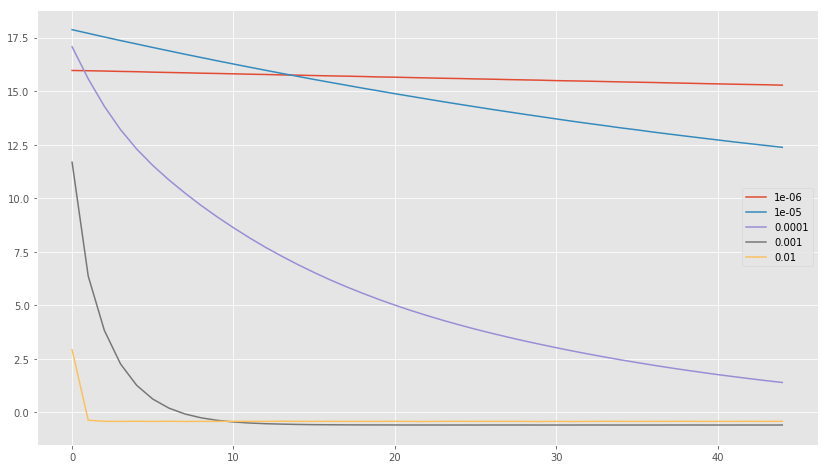

In [74]:
%%time


clf_dict = {}
for alpha in np.logspace(-6, -2, 5):
    clf_dict[alpha] = MySGDClassifier(batch_generator, 
                                      alpha=alpha, batch_size=1000)
    clf_dict[alpha].fit(X_train, y_train)
    
N = 100

for alpha, my_clf in clf_dict.items():
    loss_func = np.array(my_clf.errors_log['loss'])
    loss_mean = np.zeros((loss_func.shape[0] - 1) // N + 1)

    for ind in range(loss_mean.shape[0]):
        loss_mean[ind] = loss_func[ind * N: min((ind + 1) * N, 
                                                loss_func.shape[0])].mean()
        
    plt.plot(loss_mean, label=alpha)
    
plt.legend()

CPU times: user 1min 19s, sys: 5.18 s, total: 1min 24s
Wall time: 42.3 s


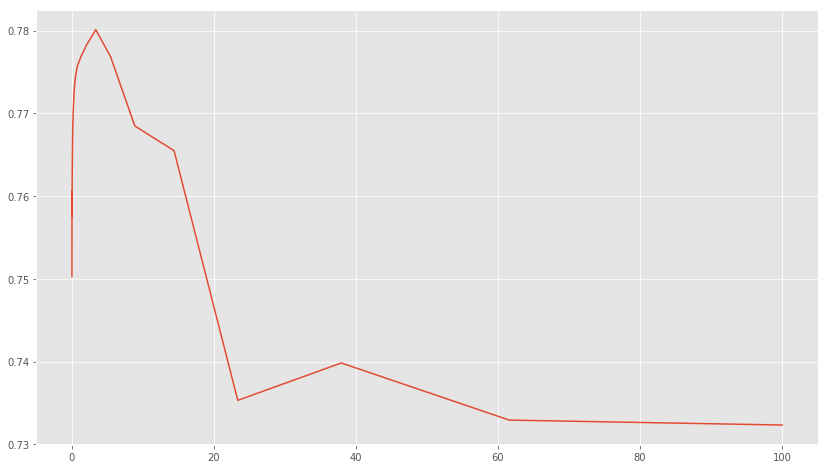

In [75]:
%%time


alpha=0.001

clf_dict = {}
for C in np.logspace(-2, 2, 20):
    clf_dict[C] = MySGDClassifier(batch_generator, alpha=alpha, C=C, batch_size=1000)
    clf_dict[C].fit(X_train, y_train)

pltl_X = []
pltl_Y = []

for C, my_clf in clf_dict.items():
    pltl_X.append(C)
    y_proba = my_clf.predict_proba(X_cross)
    pltl_Y.append(roc_auc_score(y_cross, y_proba))
    
plt_X = np.array(pltl_X)
plt_Y = np.array(pltl_Y)
plt.plot(plt_X, plt_Y)

In [76]:
final_clf = MySGDClassifier(batch_generator, alpha=0.001, C=3, batch_size=1000)
final_clf.fit(X, y)

MySGDClassifier(C=3, alpha=0.001,
        batch_generator=<function batch_generator at 0x7f47ab8286a8>,
        batch_size=1000, max_epoch=10)

## Применение модели 
* Подготовьте тестовые данные  к подаче на вход в алгоритму (нужно сделать такие же преобразования, как при обучении)
* Примените модель оцените качество на тесте с помощью меры ROC-AUC (имплментацию взять из sklern.metrics)


In [77]:
# Загрузка данных для тестирования
filepath_test = 'trainingData_tabular/trainingData_tabular_chunk2.csv'
df_data_test = pd.read_csv(filepath_test, sep=',')

In [78]:
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test['gamestate_id'] = df_data_test['gamestate_id'].astype(int)
df_data_test = df_data_test.set_index('gamestate_id')

In [79]:
df_data_test.head(10).T

gamestate_id,4240227,3026069,4859087,2003562,1215825,2765152,1905243,1675713,4475912,4267210
decision,1,1,1,1,1,0,0,0,0,0
turn,2,9,15,9,9,11,8,2,9,13
opponent_armor,0,0,0,0,0,0,0,0,0,0
opponent_attack,0,0,0,0,0,0,0,0,0,0
opponent_hero_card_id,612,25,798,25,612,494,981,494,494,326
opponent_hp,30,24,4,5,29,16,24,29,9,21
opponent_special_skill_used,0,0,0,0,0,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0,0,0,0,0,0
opponent_crystals_all,1,8,10,8,8,10,7,1,8,10
opponent_crystals_current,1,8,10,1,0,0,1,1,0,7


In [80]:
df_data_test = df_data_test.drop(['player_hand_nOfCards'], axis='columns')

oplist = df_data_test['opponent_hero_card_id'].tolist()

df_data_test['opponent_hero_card_id_is_798'] = [1 if x == 798 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_494'] = [1 if x == 494 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_25'] = [1 if x == 25 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_1235'] = [1 if x == 1235 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_612'] = [1 if x == 612 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_981'] = [1 if x == 981 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_326'] = [1 if x == 326 else 0 for x in oplist]
df_data_test['opponent_hero_card_id_is_754'] = [1 if x == 754 else 0 for x in oplist]

df_data_test = df_data_test.drop(['opponent_hero_card_id'], axis='columns')

pllist = df_data_test['player_hero_card_id'].tolist()

df_data_test['player_hero_card_id_is_798'] = [1 if x == 798 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_494'] = [1 if x == 494 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_25'] = [1 if x == 25 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_1235'] = [1 if x == 1235 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_612'] = [1 if x == 612 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_981'] = [1 if x == 981 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_326'] = [1 if x == 326 else 0 for x in pllist]
df_data_test['player_hero_card_id_is_754'] = [1 if x == 754 else 0 for x in pllist]

df_data_test = df_data_test.drop(['player_hero_card_id'], axis='columns')

In [81]:
df_data_test.head(10).T

gamestate_id,4240227,3026069,4859087,2003562,1215825,2765152,1905243,1675713,4475912,4267210
decision,1,1,1,1,1,0,0,0,0,0
turn,2,9,15,9,9,11,8,2,9,13
opponent_armor,0,0,0,0,0,0,0,0,0,0
opponent_attack,0,0,0,0,0,0,0,0,0,0
opponent_hp,30,24,4,5,29,16,24,29,9,21
opponent_special_skill_used,0,0,0,0,0,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0,0,0,0,0,0
opponent_crystals_all,1,8,10,8,8,10,7,1,8,10
opponent_crystals_current,1,8,10,1,0,0,1,1,0,7
opponent_deck_count,25,18,10,18,18,14,17,25,18,11


In [82]:
data_test = df_data.values

X_test = data_test[:, 1:].astype(float)
y_test = data_test[:, 0]

scaler.transform(X_test)

y_proba = final_clf.predict_proba(X_test)

In [83]:
roc_auc_score(y_test, y_proba)

0.7786698541727464

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

Основное отличие кроется, естественно, в различных задачах, к которым мы пытаемся применить построенную модель. Действуя в предположении о том, что по своей природе параметры каждого объекта и соответствующие им ответы связаны линейным образом (по крайней мере, после некоторых арифметических преобразований признаков), линейная регрессия решает задачу регрессии и пытается вывести явную формулу зависимости ответа от параметров, в то время как логистическая регрессия решает задачу бинарной классификации и ищет уравнение разделяющей (в случае линейной разделимости объектов, что снова относит к проблеме выбора системы параметров) классы гиперплоскости. Более того, получаемое уравнение гиперплоскости обычно не преподносится пользователю явно как результат, подставляя параметры в который можно получить информацию, связанную с принадлежностью объекта к тому или иному классу; она проходит обработку отражающей её в "вероятностный" отрезок $[0, 1]$ сигмоидой (или любой другой схожей по действию функцией). Также результаты логистической регрессии требуют немного иного подхода к построению функции потерь. В конце концов, в оригинальной своей постановке задача линейного разделения может иметь в качестве решения семейство гиперплоскостей, тогда как для задачи решения переопределённой системы уравнений (по крайней мере, для случая невырожденной матрицы левой части) формулируется существование однозначного решения.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

Во-первых, мне кажется, что данных должно быть много — слишком малое их количество может привести к overfitting'у. Логичным будет использование линейной модели в том случае, если визуально наблюдается какая-то явная зависимость (линейная, квадратичная, логарифмическая и так далее) между параметром и ответом. Возможно, слишком большое исходное количество параметров (которое при попытке различными арифметическими операциями над ними подобрать схожую с "истинной природной" зависимость в разы вырастет) будет приводить как к overfitting'у, так и к медленной работе алгоритма. Также категориальные признаки выглядят препятствием к успешному моделированию из-за своей ярко выраженной дискретности, в то время как выстраиваемые нами формула регрессии и уравнение разделяющей гиперплоскости являются непрерывными функциями. 

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

Подсчёт градиента состоит из операции умножения $X\beta$, вычитания из результата $y$, последующего умножения на $X^T$ и деления на скаляр $n$. Сложность можно оценить как $O(ND) + O(N) + O(ND) + O(D) = O(ND)$. Последующее домножение градиента на нормировочный $\alpha$ и пересчёт градиента имеют сложность $O(D)$. Таким образом, алгоритмическая сложность шага градиентного спуска — $O(ND)$.

Шаг стохастического градиентного спуска будет состоять из тех же самых операций, но на месте матрицы размера $N$x$D$ мы будем иметь только одну её строку. Тогда алгоритмическая сложность шага стохастического градиентного спуска — $O(D)$.

Предсказание на одном объекте формально (если не учитывать нормализацию и какие-то другие сопутствующие процедуры) состоит из одной операции вычисления скалярного произведения вектора признаков и вектора весов в пространстве размерности $D$. Тогда алгоритмическая сложность — $O(D)$. 

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

В большинстве случаев стохастический градиентный спуск за эпоху даёт более заметные разультаты, чем один шаг обычного градиентного спуска при сопоставимых алгоритмических сложностях. Таких образом, скорость сходимости стохастической реализации зачастую заметно превосходит скорость обычной. Основным недостатком является то, что в общем случае сходимость стохастического градиентного спуска не гарантируется. В предположении сходимости стохастического метода он получает не только преимущество в скорости сходимости при одинаковом времени работы, но и преимущество в требуемых ресурсах на вычисление каждого шага. Оптимально подобранный размер мини-батча позволяет найти компромисс между использованием памяти и временем работы, в то время как регулировать этот баланс для обычного градиентного спуска можно лишь изменением размера тренировочного сета, что может уменьшить точность модели.

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

Я считаю, что ошибку на новом объекте стоит считать до итерации спуска на нём, поскольку тогда её значение будет отражать общую эффективность предсказания нашей модели в противовес отражению эффективности предсказания нашей модели на тренировочном сете.

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

Модели должны выбираться в зависимости от рассматриваемой задачи; если мы попробуем предсказать почти идеально ложащиеся на экспоненциальную кривую точки на плоскости признак-значение многослойной нейронной сетью, вряд ли она сможет превзойти по точности примитивную подходящую линейную модель, при этом значительно проигрывая в скорости тренировки и предсказания. Даже в случае незнакомого по внутренней природе набора данных линейную модель можно использовать для попытки первичного анализа и предсказания без сильных затрат по времени разработки и тренировки.

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Вот как раз при ответе на вопрос я понял, что речи о сходимости стохастического метода совсем не захотило, а подобные знания явно не помешали бы.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

Как раз к этой домашней работе это применимо в значительно меньшей степени, но объёмы реверс-инжиниринга просто поражают. Без лишних комментариев неясно, что должна делать та или иная функция, которую нам надо написать; временами проблема становится ещё глубже, и при понимании сути функции совершенно не ясна требуемая форма реализации, которая может отличаться как и от написанной в sklearn, так и от написанного в лекциях. При выполнении заданий, кстати, лекции практически бесполезны, за исключением возможности освежить общие концепты в голове. За более глубокими тонкостями приходится идти в гугл, отчаянно листать сурсы sklearn'а или играться с методом тыка. То же можно отнести и к вопросам, которые выдаются на большинстве квизов. Ответ на них куда чаще проще найти через гугл, нежели в лекции по теме, да и далеко не всегда оно там (именно в ноутбуке) вообще затрагивается. И всё это приводит также к тому, что для выполнения выделенного на неделю (опять же, обращаясь к предыдущим случаям) задания уходит всё свободное и не очень время всей этой недели.

Кстати, использовать меняющийся при каждом обновлении ядра ноутбука хэш для генерации задания -- такая себе идея. У меня в первый раз аж сердечко ёкнуло от неожиданности; пришлось роллить то, что уже начал реализовывать (что в свою очередь ломает смысл этой генерации).